In [10]:
%reset -f

# from pandasgui import show

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import acorr_ljungbox

%load_ext autoreload
%autoreload 2

# Load data
data = pd.read_csv('Data/non_nan_data.csv')
data = data.drop(['sun_mean', 'wind_mean', 'temp_mean', 'DK1_spot'], axis=1)

# Split data
data_train = data[(data['DATE'] >= '2018-01-01') & (data['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy()
data_test = data[data['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy()

# To only use weather data one hour before the price, we lag weather data one hour
y_train = data_train[:, 0].reshape(-1, 1)[1::]
y_test = data_test[:, 0].reshape(-1, 1)[1::]

weather_train = data_train[:, 1:-2][:-1, :]
weather_test = data_test[:, 1:-2][:-1, :]

hour_dummies_train = sdummy(len(data_train), 24)[:-1, :]
hour_dummies_test = sdummy(len(data_test), 24)[:-1, :]

all_train = np.concatenate((weather_train, hour_dummies_train), axis=1)
all_test = np.concatenate((weather_test, hour_dummies_test), axis=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Baseline

In [17]:
p = 1

con = 0
tr = 0
exog = 0
# exog = weather
# exog = hour_dummies_train
# exog = all_train

Beta, SEbeta, _, Pvalue, tratioBeta, res_baseline, _, _, aiccrit, hqccrit, siccrit = VARlsExog(y_train, p, con, tr, exog)

# # Collect beta, SEbeta and tratioBeta in a single dataframe
results = pd.DataFrame()
results['Beta'] = Beta.reshape(-1, order='F')


X_test = np.column_stack([lagmatrix(y_test, p)])

y_pred = X_test @ Beta

smape_baseline = smape(y_test[p::], y_pred[p::])

print(f'SMAPE baseline out of sample prediction: {smape_baseline}')

SMAPE baseline out of sample prediction: 23.728607987696645


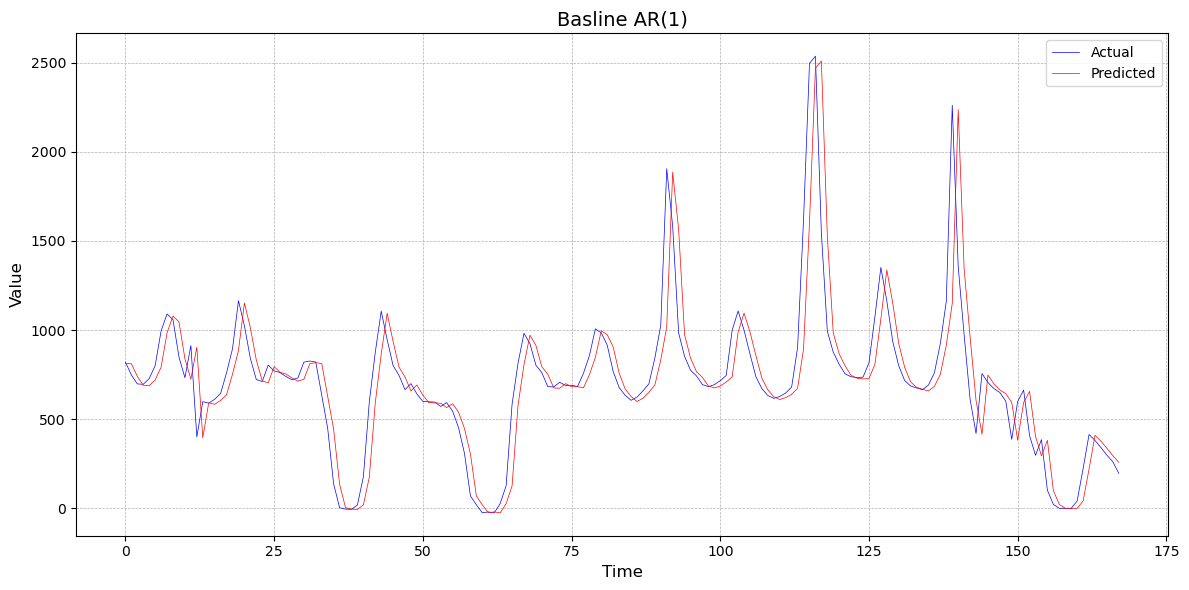

In [18]:
plot_actual_vs_predicted(y_test, y_pred, "Basline AR(1)")

## Baseline with 24 lags

In [13]:
p = 24


con = 0
tr = 0
exog = 0
# exog = weather
# exog = hour_dummies_train
# exog = all_train

Beta, SEbeta, _, Pvalue, tratioBeta, res_baseline, _, _, aiccrit, hqccrit, siccrit = VARlsExog(y_train, p, con, tr, exog)

# # Collect beta, SEbeta and tratioBeta in a single dataframe
results = pd.DataFrame()
results['Beta'] = Beta.reshape(-1, order='F')


X_test = np.column_stack([lagmatrix(y_test, p)])

y_pred = X_test @ Beta

smape_baseline = smape(y_test[p::], y_pred[p::])

print(f'SMAPE baseline (24 lags) out of sample prediction: {smape_baseline}')

SMAPE baseline (24 lags) out of sample prediction: 23.04176870630518


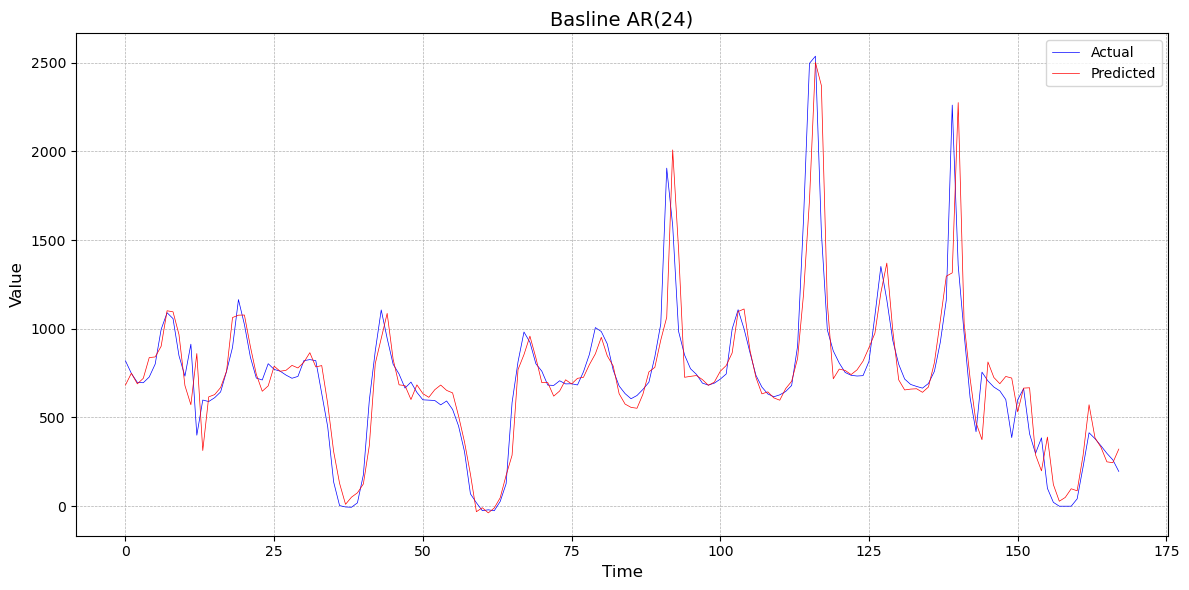

In [14]:
plot_actual_vs_predicted(y_test, y_pred, "Basline AR(24)")

## Extended baseline with weather data

In [15]:
p = 1
con = 0
tr = 0
# exog = weather_train
# exog = hour_dummies_train
exog = all_train

Beta, SEbeta, _, Pvalue, tratioBeta, _, _, _, aiccrit, hqccrit, siccrit = VARlsExog(y_train, p, con, tr, exog)

# # Collect beta, SEbeta and tratioBeta in a single dataframe
results = pd.DataFrame()
results['Beta'] = Beta.reshape(-1, order='F')


X_test = np.column_stack([lagmatrix(y_test, p), all_test])

y_pred = X_test[p::, :] @ Beta

smape_baseline_extended = smape(y_test[p::, :] , y_pred)

print(f'SMAPE baseline (with exogenous) out of sample prediction: {smape_baseline_extended}')

SMAPE baseline (with exogenous) out of sample prediction: 24.120054255576086


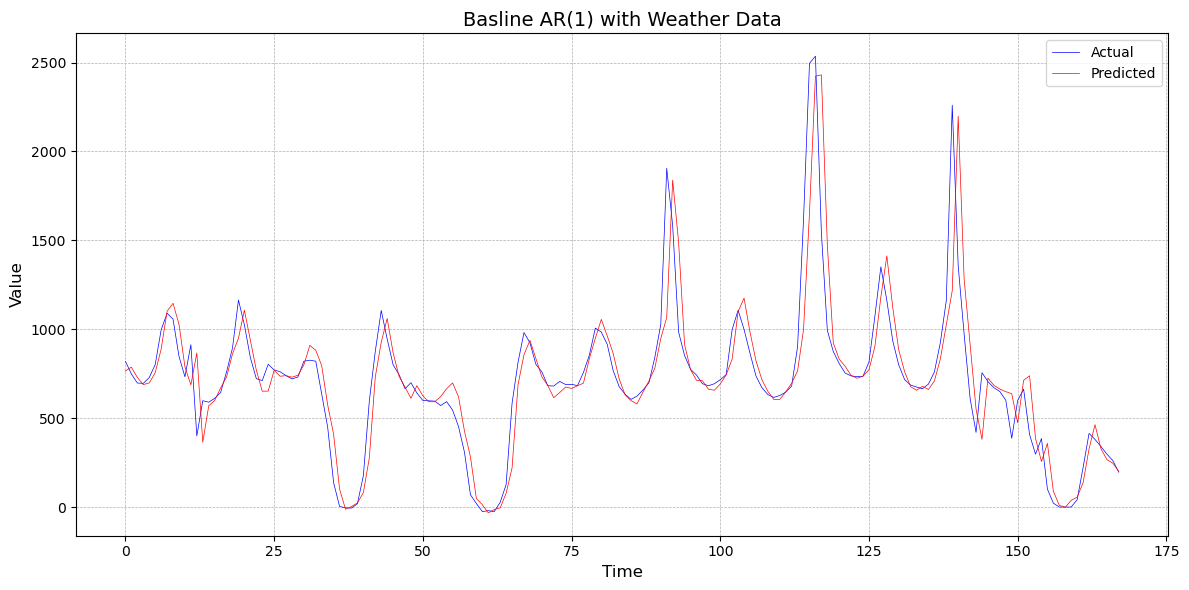

In [16]:
plot_actual_vs_predicted(y_test, y_pred, "Basline AR(1) with Weather Data")